In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from core import med_log_odds_cutoff, bw_color_palette
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter

In [3]:
def select_domains(hhblits_df, prob_cutoff=50):
    # Other Domains
    out_list = []
    for group, group_df in tqdm(hhblits_df[(hhblits_df['Prob'] > prob_cutoff)].groupby('query'), 
                                position=0, total=hhblits_df['query'].nunique()):
        group_df = group_df.sort_values('Prob', ascending=False)
        while len(group_df):
            selected_row = group_df.head(1).squeeze()
            out_list.append(selected_row)
            group_df = group_df[(group_df['qend'] < selected_row['qstart']) |
                                (group_df['qstart'] > selected_row['qend'])]
    selected_domain_df = pd.concat(out_list, axis=1).T
    return selected_domain_df

In [4]:
def to_percent_no_sign(x, pos):
    return f"{100 * x:.0f}"

In [5]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [6]:
qcov=0.4

In [7]:
search_df = pd.read_table('../data3/interim/ecor_put_nov_df_rep_search.txt',
                          names=["query", "target", "fident", "alnlen", "mismatch", "gapopen", "qstart", "qend", "tstart", "tend", "qcov", "tcov", "evalue", "bits", "alntmscore", "qtmscore", "ttmscore", "rmsd", "lddt", "prob"])
predictions = pd.read_csv('../data3/interim/ecor_predictions_defensive_cat.csv')
hhpred_results = pd.read_csv('../data3/interim/ecor_putative_novel_pfam_df_domains.csv')
pfam_clans = pd.read_table('../data/raw/Pfam-A.clans.tsv', 
                           names=['pfam_id', 'clan_id', 'clan_name', 'pfam_name', 'pfam_description'])

/state/partition1/slurm_tmp/2712844.0.0/ipykernel_2502719/2108960330.py:3: DtypeWarning: Columns (24,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  predictions = pd.read_csv('../data3/interim/ecor_predictions_defensive_cat.csv')


In [8]:
blacklisted_domains = pd.read_csv('../data3/interim/df_blacklisted_domains.csv')

In [9]:
top_search_df = (search_df.sort_values('prob', ascending=False)
                 .groupby('query')
                 .head(1))

In [10]:
homolog_df = (top_search_df[top_search_df['prob'] > 0.6]
              .reset_index(drop=True))

In [11]:
merged_predictions = (predictions
                      .merge(homolog_df
                             .rename(columns={'query': 'product_accession',
                                              'target': 'foldseek_hit',
                                              'prob': 'foldseek_prob',
                                              'qcov': 'foldseek_q_cov'}), 
                             how='left', on='product_accession'))
merged_predictions['foldseek_q_cov'] = merged_predictions['foldseek_q_cov'].fillna(0)

In [12]:
def assign_hit_category(row, cutoff=med_log_odds_cutoff, qcov=qcov):
    if row['defense_system_protein']:
        return 'Defense homolog in expected system'
    elif row['mean_log_odds'] > cutoff:
        if row['defense_homolog']:
            return 'Defense homolog in new context'
        elif (row['q_cov'] > qcov):
            return 'Remote defense homolog'
        elif(row['foldseek_q_cov'] > qcov):
            return 'Structural defense homolog'
        else: 
            return 'Predicted novel defense gene'
    else:
        return 'Not defensive'

In [13]:
merged_predictions['hit_category'] = merged_predictions.apply(assign_hit_category, axis=1)
hit_categories = ['Defense homolog in expected system',
                  'Defense homolog in new context', 
                  'Remote defense homolog', 
                  'Structural defense homolog',
                  'Predicted novel defense gene', 
                  'Not defensive']
merged_predictions['hit_category'] = pd.Categorical(merged_predictions['hit_category'], 
                                                    categories=hit_categories)

In [ ]:
merged_predictions.to_csv('../data3/interim/ecor_predictions_defensive_cat2.csv', index=False)


In [14]:
merged_predictions['hit_category'].value_counts()

hit_category
Not defensive                         319225
Defense homolog in new context          1009
Predicted novel defense gene             496
Defense homolog in expected system       395
Remote defense homolog                   176
Structural defense homolog                46
Name: count, dtype: int64

In [15]:
non_redundant_predictions = (merged_predictions
                             .sort_values(['hit_category', 'mean_log_odds'], ascending=[True, False])
                             .groupby('cluster_id')
                             .head(1))

In [16]:
non_redundant_predictions['hit_category'].value_counts()

hit_category
Not defensive                         10590
Defense homolog in new context          219
Predicted novel defense gene            168
Defense homolog in expected system      152
Remote defense homolog                  103
Structural defense homolog               22
Name: count, dtype: int64

In [17]:
len(non_redundant_predictions)

11254

In [18]:
(non_redundant_predictions['mean_log_odds'] > 0).sum()

1085

In [19]:
non_redundant_predictions['defense_system_protein'].sum()

152

In [20]:
total_pred = len(non_redundant_predictions)
print('Total # genes', total_pred)
g_p5 = (non_redundant_predictions['mean_log_odds'] > 0).sum()
print('# Genes with P > 0.5', g_p5)
print('Frac genes with P > 0.5', round(g_p5/total_pred, 3))
g_cutoff = (non_redundant_predictions['mean_log_odds'] > med_log_odds_cutoff).sum()
print('# genes with LO >', round(med_log_odds_cutoff, 3), g_cutoff)
print('frac. genes with LO >', round(med_log_odds_cutoff, 3), round(g_cutoff/total_pred, 3))


Total # genes 11254
# Genes with P > 0.5 1085
Frac genes with P > 0.5 0.096
# genes with LO > 4 624
frac. genes with LO > 4 0.055


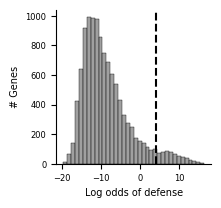

In [21]:
plt.subplots(figsize=(2,2))
sns.histplot(non_redundant_predictions['mean_log_odds'], binwidth=1, 
             color='grey')
plt.xlabel('Log odds of defense')
plt.ylabel('# Genes')
plt.axvline(x=med_log_odds_cutoff, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/hit_distribution_nr.svg', dpi=300, bbox_inches='tight')

In [22]:
filtered_nr_predictions = non_redundant_predictions[non_redundant_predictions['mean_log_odds'] > med_log_odds_cutoff].copy()
filtered_nr_predictions['accession_stub'] = (filtered_nr_predictions['product_accession']
                                          .str.split('.', expand=True)[0])
filtered_nr_predictions['hit_category'] = filtered_nr_predictions['hit_category'].cat.remove_unused_categories()

In [23]:
filtered_nr_predictions['hit_category'].value_counts()/len(filtered_nr_predictions)

hit_category
Defense homolog in new context        0.350962
Predicted novel defense gene          0.269231
Defense homolog in expected system    0.179487
Remote defense homolog                0.165064
Structural defense homolog            0.035256
Name: count, dtype: float64

In [24]:
filtered_nr_predictions['hit_category'].value_counts()

hit_category
Defense homolog in new context        219
Predicted novel defense gene          168
Defense homolog in expected system    112
Remote defense homolog                103
Structural defense homolog             22
Name: count, dtype: int64

In [25]:
non_redundant_predictions['defense_system_protein'].sum()

152

In [26]:
non_redundant_predictions.loc[(non_redundant_predictions['mean_log_odds'] <= med_log_odds_cutoff) & 
            (non_redundant_predictions['defense_system_protein']), 'defense_homolog_names'].value_counts()

defense_homolog_names
RM_Type_IV__Type_IV_REases                                                                                                                  3
CBASS__Phospholipase                                                                                                                        2
CBASS__AG_E1_ThiF, CBASS__AG_E2_Prok-E2_B                                                                                                   2
Shango__SngC, PsyrTA__PsyrT                                                                                                                 2
dCTPdeaminase__dCTPdeaminase                                                                                                                2
CBASS__Jab                                                                                                                                  1
BREX__brxHII, DISARM_1__drmD                                                                                                  

In [27]:
novel_pred_df = (filtered_nr_predictions[filtered_nr_predictions['hit_category'] == 'Predicted novel defense gene']
                 .sort_values('q_cov', ascending=True)
                 .reset_index(drop=True))
novel_pred_df['present'] = 1
novel_pred_df['n_proteins'] = novel_pred_df['present'].cumsum()

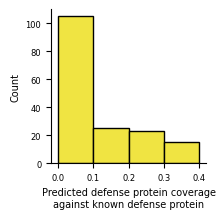

In [28]:
plt.subplots(figsize=(2,2))
sns.histplot(data=novel_pred_df, 
             x='q_cov', binwidth=0.1, color='#f0e442', alpha=1)
plt.xlabel('Predicted defense protein coverage\nagainst known defense protein')
sns.despine()
plt.savefig('../figures/novel_coverage_nr.svg', dpi=300, bbox_inches='tight')

In [29]:
novel_cov_abundance = (novel_pred_df
                       .groupby('q_cov')
                       .agg(n_proteins=('product_accession', 'count'))
                       .reset_index()
                       .sort_values('q_cov'))
novel_cov_abundance['tot_n_proteins'] = novel_cov_abundance['n_proteins'].cumsum()

In [30]:
novel_cov_abundance

,q_cov,n_proteins,tot_n_proteins
0,0.000000,103,103
1,0.065000,1,104
2,0.098160,1,105
3,0.100000,1,106
4,0.102894,1,107
...,...,...,...
61,0.390110,1,164
62,0.392505,1,165
63,0.396142,1,166
64,0.397213,1,167


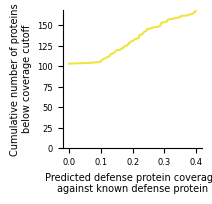

In [31]:
plt.subplots(figsize=(1.8,1.8))
sns.lineplot(data=novel_cov_abundance,
             x='q_cov', y='tot_n_proteins', color='#f0e442', alpha=1)
plt.xlabel('Predicted defense protein coverage\nagainst known defense protein')
plt.ylabel('Cumulative number of proteins\nbelow coverage cutoff')
sns.despine()
plt.ylim(0, novel_cov_abundance['tot_n_proteins'].max() + 1)
plt.savefig('../figures/novel_coverage_cumsum_nr.svg', dpi=300, bbox_inches='tight')

In [32]:
(novel_pred_df['q_cov'] == 0).sum()

103

In [33]:
((novel_pred_df['q_cov'] > 0) & (novel_pred_df['q_cov'] < 0.4)).sum()

65

In [34]:
(novel_pred_df['q_cov'] <= 0.1).sum()

106

In [35]:
((novel_pred_df['q_cov'] == 0) & (novel_pred_df['foldseek_q_cov'] == 0)).sum()

103

In [36]:
color_palette = sns.color_palette(['#e69f00', '#56b4e9', '#009e73', '#0072b2','#f0e442'])

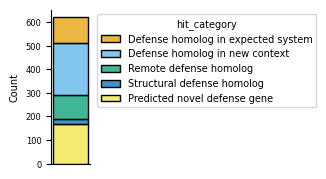

In [37]:
_, ax = plt.subplots(figsize=(0.5, 2))
ax = sns.histplot(data=filtered_nr_predictions, x=0, 
             hue='hit_category', 
             multiple='stack', 
             palette=color_palette, ax=ax, )
sns.move_legend(ax, bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.xticks([])
plt.xlabel('')
plt.savefig('../figures/predicted_defense_known_frac_nr.svg', dpi=300, bbox_inches='tight')

In [38]:
pfam_results = hhpred_results[(hhpred_results['hit_name'].str[:2] == 'PF') & 
                              (hhpred_results['Prob'] > 50)].copy()
pfam_results['pfam_id'] = pfam_results['hit_name'].str.split('.', expand=True)[0]
pfam_results = pfam_results.merge(pfam_clans, how='left', on='pfam_id')

In [39]:
nr_novel_accessions = novel_pred_df['product_accession']
nr_novel_pfam_results = pfam_results[pfam_results['query'].isin(nr_novel_accessions)]
nr_novel_pfam_clans = (nr_novel_pfam_results[['query', 'clan_name']]
                    .drop_duplicates())

In [40]:
nr_select_novel_pfam_domains = select_domains(nr_novel_pfam_results)

100%|██████████| 128/128 [00:00<00:00, 563.08it/s]


In [41]:
(nr_select_novel_pfam_domains[['query','pfam_name', 'clan_name']].drop_duplicates()
 [['pfam_name', 'clan_name']]
 .value_counts()
 .head(20))

pfam_name       clan_name     
RepB-RCR_reg    Met_repress       7
NinG            His-Me_finger     5
IIGP            P-loop_NTPase     3
Response_reg_2  CheY              3
HATPase_c_5     His_Kinase_A      3
Dynamin_N       P-loop_NTPase     3
AAA_35          P-loop_NTPase     2
DpnII-MboI      PDDEXK            2
KicB            HTH               2
ATP-synt_B      ATP_synthase      2
PDDEXK_4        PDDEXK            2
PIN             PIN               2
Metallophos_3   Calcineurin       2
Mrr_cat_2       PDDEXK            2
Polbeta         NTP_transf        2
RNA12           P-loop_NTPase     1
pP_pnuc_2       SPOCS             1
pEK499_p136     KNTase_C          1
NERD            PDDEXK            1
NinF            Zn_Beta_Ribbon    1
Name: count, dtype: int64

In [42]:
nr_novel_pfam_clan_count = (nr_select_novel_pfam_domains.groupby('clan_name')
                         .agg(count=('query', 'nunique'))
                         .rename(index={'P-loop_NTPase': 'P-loop NTPase', 
                                        'PDDEXK': 'PDDEXK nuclease', 
                                        'PEP-carboxyk': 'PEP carboxykinase',
                                        'Met_repress': 'RHH antitoxin DNA binding', 
                                        'KNTase_C': 'HEPN', 
                                        'His-Me_finger': 'HNH endonuclease', 
                                        'Zn_Beta_Ribbon': 'Zinc finger', 
                                        'His_Kinase_A': 'His kinase phospho-acceptor', 
                                        'CheY': 'Response regulator'})
                         .sort_values('count', ascending=False)
                         .reset_index())
nr_novel_pfam_clan_count['freq'] = nr_novel_pfam_clan_count['count']/len(nr_novel_accessions)

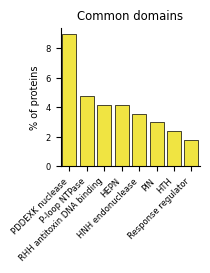

In [43]:
plt.subplots(figsize=(1.8,1.8))
sns.barplot(data=nr_novel_pfam_clan_count.head(8), x='clan_name', y='freq', 
            color=bw_color_palette[3], linewidth=0.5, edgecolor='black', saturation=100)
sns.despine()
plt.xticks(rotation=45, ha='right')
plt.ylabel('% of proteins')
plt.xlabel('')
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent_no_sign))
plt.title('Common domains')
plt.savefig('../figures/predicted_novel_defense_domains_nr.svg', dpi=300, bbox_inches='tight')

In [44]:
nr_novel_pfam_clan_count.head(8)

,clan_name,count,freq
0,PDDEXK nuclease,15,0.089286
1,P-loop NTPase,8,0.047619
2,RHH antitoxin DNA binding,7,0.041667
3,HEPN,7,0.041667
4,HNH endonuclease,6,0.035714
5,PIN,5,0.029762
6,HTH,4,0.023810
7,Response regulator,3,0.017857


In [45]:
novel_cluster_known_domains_n = nr_select_novel_pfam_domains.loc[nr_select_novel_pfam_domains['pfam_id']
                                 .isin(blacklisted_domains['pfam_id']), 'query'].nunique()

In [46]:
novel_cluster_known_domains_n

83

In [47]:
len(nr_novel_accessions)

168

In [48]:
novel_cluster_known_domains_n/len(nr_novel_accessions)

0.49404761904761907

In [49]:
cluster_n_genomes = (predictions.groupby('cluster_id')
                     .agg(n_genomes=('assembly', 'nunique'))
                     .reset_index())
predicted_novel_defense_clusters = merged_predictions.loc[merged_predictions['hit_category'] == 'Predicted novel defense gene', 
                                                          ['cluster_id']].drop_duplicates()
pnd_clusters_n_genomes = (predicted_novel_defense_clusters.merge(cluster_n_genomes, 
                                                                how='inner', on='cluster_id'))
pnd_clusters_n_genomes['category'] = 'Predicted novel\ndefense genes'
known_defense_clusters = predictions.loc[predictions['defense_system_protein'], 
                                         ['cluster_id']].drop_duplicates()
kd_clusters_n_genomes = (known_defense_clusters.merge(cluster_n_genomes, 
                                                      how='inner', on='cluster_id'))
kd_clusters_n_genomes['category'] = 'All defense homologs\nin expected systems'
cluster_n_genomes['category'] = 'All genes'
cluster_categories_n_genomes = pd.concat([cluster_n_genomes, pnd_clusters_n_genomes, kd_clusters_n_genomes], axis=0)
cluster_categories_n_genomes['category'] = pd.Categorical(cluster_categories_n_genomes['category'], 
                                                              categories=['All genes',
                                                                  'All defense homologs\nin expected systems',
                                                                'Predicted novel\ndefense genes'])

In [50]:
cluster_n_genomes = (predictions.groupby('cluster_id')
                     .agg(n_genomes=('assembly', 'nunique'))
                     .reset_index())
cluster_n_genomes['category'] = 'All protein clusters'
novel_clusters = non_redundant_predictions.loc[non_redundant_predictions["hit_category"] == 'Predicted novel defense gene', 
                                               'cluster_id']
novel_n_genomes = cluster_n_genomes[cluster_n_genomes['cluster_id'].isin(novel_clusters)].copy()
novel_n_genomes['category'] = 'Predicted novel defense'
known_clusters = non_redundant_predictions.loc[non_redundant_predictions["hit_category"] == 'Defense homolog in expected system', 
                                               'cluster_id']
known_n_genomes = cluster_n_genomes[cluster_n_genomes['cluster_id'].isin(known_clusters)].copy()
known_n_genomes['category'] = 'Defense homologs in expected system'
cluster_categories_n_genomes = pd.concat([cluster_n_genomes, novel_n_genomes, known_n_genomes], axis=0)
cluster_categories_n_genomes['category'] = pd.Categorical(cluster_categories_n_genomes['category'], 
                                                              categories=['All protein clusters',
                                                                  'Defense homologs in expected system',
                                                                'Predicted novel defense'])

In [51]:
cluster_categories_n_genomes['accessory_gene'] = cluster_categories_n_genomes['n_genomes'] <= 5

In [52]:
(cluster_categories_n_genomes.groupby('category')
 .agg(frac_accessory=('accessory_gene', lambda x: x.sum()/len(x))))

,frac_accessory
category,
All protein clusters,0.521237
Defense homologs in expected system,0.697368
Predicted novel defense,0.892857


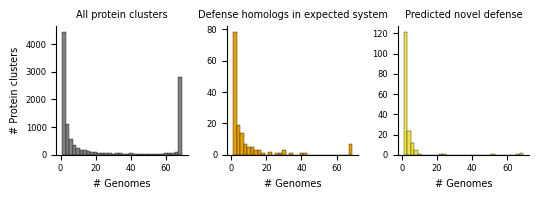

In [53]:
g = sns.displot(data=cluster_categories_n_genomes, x='n_genomes', binwidth=2, 
                hue='category', palette=(['grey', '#e69f00', '#f0e442']), 
                col='category', kind='hist', facet_kws={'sharey': False}, 
                alpha=1, height=2, legend=False, aspect=0.9)
g.set_titles(template='{col_name}')
g.set_xlabels('# Genomes')
g.set_ylabels('# Protein clusters')
g.figure.subplots_adjust(wspace=0.3)
plt.savefig('../figures/cluster_distribution.svg', dpi=300, bbox_inches='tight')

In [54]:
nr_select_novel_pfam_domains.to_csv('../data3/interim/ecor_unique_novel_pfam_domains.csv', index=False)

In [55]:
novel_pred_df.to_csv('../data3/interim/ecor_unique_novel_proteins.csv', index=False)